In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import defaultdict


In [4]:
now = datetime.datetime.now()
this_year = now.year

In [3]:
# Make a request for the data
req = requests.get('https://www.spotrac.com/nba/free-agents/')
req.status_code
# get just the content from the html
content = req.content
soup = BeautifulSoup(content)
# Get only the table from the webpage
tables = soup.find_all('table')
# Turn the table to a pandas dataframe
data_2019 = pd.read_html(str(tables))
# Output was a list. Get the dataframe out of the list
data_2019 = data_2019[0]

data_2019['Salary'] = data_2019['2018-2019 AAV']
data_2019.drop(['2018-2019 AAV','Rights'],axis=1,inplace=True)
data_2019['Player'] = data_2019.iloc[:,0]
data_2019.drop(data_2019.iloc[:,0].name,axis=1,inplace=True)
data_2019['Salary'] = data_2019['Salary'].apply(lambda x: x.replace('$','').replace(',',''))
data_2019.set_index('Player',inplace=True)

In [5]:
# list of years to scrape data for
years = list(range(2011,this_year))

# loop through the years to make a new dataframe for each year
for year in years:
    req = requests.get('https://www.spotrac.com/nba/free-agents/' + str(year))
    content = req.content
    soup = BeautifulSoup(content)
    tables = soup.find_all('table')
    # creates a variable for each year
    # ex. data_2011
    globals()['data_%s' % year] = pd.read_html(str(tables))
    globals()['data_%s' % year] = globals()['data_%s' % year][0]
    # Take out totals row and cap hit column
    globals()['data_%s' % year].drop(globals()['data_%s' % year].tail(1).index,inplace=True)
    globals()['data_%s' % year].drop(['{} Cap Hit'.format(year),'Dollars','Age'],axis=1,inplace=True)
    globals()['data_%s' % year]['Year of Free Agency'] = year
    globals()['data_%s' % year]['Player'] = globals()['data_%s' % year].iloc[:,0]
    globals()['data_%s' % year]['Player'] = globals()['data_%s' % year]['Player'].apply(lambda x: x.replace('.','').replace("'",''))
    globals()['data_%s' % year].drop(globals()['data_%s' % year].iloc[:,0].name,axis=1,inplace=True)
    globals()['data_%s' % year].drop_duplicates(subset='Player',keep='first',inplace=True)
    globals()['data_%s' % year].set_index('Player',inplace=True)

In [6]:
data = []
for year in years:
    data.append(globals()['data_%s' % year])

In [7]:
data=pd.concat(data)

In [8]:
playoffs_2011 = ['IND','MIA','CHI','POR','DAL','PHI','ATL','NYK','SAS','OKC','DEN','LAL','BOS','ORL','CHA','MEM']
playoffs_2012 = ['PHI','CHI','ORL','IND','NYK','MIA','DAL','OKC','BOS','ATL','DEN','LAL','LAC','MEM','UTH','SAS']
playoffs_2013 = ['CHI','BKN','GSW','DEN','MEM','LAC','BOS','NYK','ATL','IND','MIL','MIA','HOU','OKC','LAL','SAS']
playoffs_2014 = ['ATL','IND','GSW','LAC','MEM','OKC','BKN','TOR','WAS','CHI','POR','HOU','CHA','MIA','DAL','SAS']
playoffs_2015 = ['MIL','CHI','NOP','GSW','DAL','HOU','WAS','TOR','BKN','ATL','BOS','CLE','SAS','LAC','POR','MEM']
playoffs_2016 = ['BOS','ATL','HOU','GSW','DAL','OKC','IND','TOR','DET','CLE','POR','LAC','CHA','MIA','MEM','SAS']
playoffs_2017 = ['IND','CLE','UTH','LAC','MEM','SAS','MIL','TOR','CHI','BOS','POR','GSW','OKC','HOU','ATL','WAS']
playoffs_2018 = ['SAS','GSW','MIA','PHI','NOP','POR','WAS','TOR','MIL','BOS','IND','CLE','MIN','HOU','UTH','OKC']

In [9]:
# Get data for players stats for every year
for year in years:
    req = requests.get("https://www.basketball-reference.com/leagues/NBA_{}_per_game.html".format(year))
    content = req.content
    soup = BeautifulSoup(content)
    tables = soup.find('table')
    globals()['stats_%s' % year] = pd.read_html(str(tables))
    globals()['stats_%s' % year] = globals()['stats_%s' % year][0]
    globals()['stats_%s' % year].drop(['Rk','DRB','ORB'],axis=1,inplace=True)
    globals()['stats_%s' % year].drop_duplicates(subset='Player',keep='last',inplace=True)
    globals()['stats_%s' % year]['Player'] = globals()['stats_%s' % year]['Player'].apply(lambda x: x.replace("'",'')
                                                                                          .replace('.','')
                                                                                          .replace('*',''))
    globals()['stats_%s' % year].set_index('Player',inplace=True)
    globals()['stats_%s' % year]['Year'] = year
    globals()['stats_%s' % year]['Playoffs'] = globals()['stats_%s' % year]['Tm'].apply(lambda x: True if x in globals()['playoffs_%s' % year] else False).astype(int)

In [10]:
stats_data = []
for year in years:
    stats_data.append(globals()['stats_%s' % year])
stats_data = pd.concat(stats_data)

In [34]:
for year in years:
    last = year - 1
    req = requests.get('https://hoopshype.com/salaries/players/{}-{}/'.format(str(last),year))
    content = req.content
    soup = BeautifulSoup(content)
    tables = soup.find('table')
    a = pd.read_html(str(tables))
    a = a[0]
    a = a.drop_duplicates(subset='Player',keep='first')
    a.set_index('Player',inplace=True)
    a['Year'] = year
    a['Salary'] = a['{}/{}'.format(last,str(year)[2:])]
    globals()['salary_%s' % year] = a[['Salary','Year']]
    globals()['salary_%s' % year]['Salary'] = globals()['salary_%s' % year]['Salary'].apply(lambda x: x.replace('$','').replace(',','').replace("'",''))

/Users/MSteele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
salary_data = []
for year in years:
    salary_data.append(globals()['salary_%s' % year])
salary_data = pd.concat(salary_data)

In [160]:
stats_data.rename(index={'Tim Hardaway':'Tim Hardaway Jr'},inplace=True)
stats_data.rename(index={'Patty Mills':'Patrick Mills'},inplace=True)
stats_data.rename(index={'Ish Smith':'Ishmael Smith'},inplace=True)
stats_data.rename(index={'JJ Barea': 'Jose Barea'},inplace=True)
stats_data.rename(index={'Pooh Jeter':'Eugene Jeter'},inplace=True)
stats_data.rename(index={'Byron Mullens':'BJ Mullens'},inplace=True)
stats_data.rename(index={'Glenn Robinson':'Glenn Robinson III'},inplace=True)
stats_data.rename(index={'Lou Amundson':'Louis Amundson'},inplace=True)
stats_data.rename(index={'Lou Williams':'Louis Williams'},inplace=True)
salary_data.rename(index={'Jose Juan Barea':'Jose Barea'},inplace=True)
salary_data.rename(index={'Aleksandar Pavlovic':'Sasha Pavlovic'},inplace=True)
salary_data.rename(index={'Hidayet Turkoglu':'Hedo Turkoglu'},inplace=True)
salary_data.rename(index={'Maurice Williams':'Mo Williams'},inplace=True)
salary_data.rename(index={'Nenê':'Nene Hilario'},inplace=True)
salary_data.rename(index={'Kelenna Azubuike':'Kelenna Azubuike'},inplace=True)
salary_data.rename(index={'Predrag Stojakovic':'Peja Stojakovic'},inplace=True)
data.rename(index={'Luc Richard Mbah a Moute':'Luc Mbah a Moute'},inplace=True)
salary_data.rename(index={'John Lucas':'John Lucas III'},inplace=True)
data.rename(index={'Darrun Hilliard II':'Darrun Hilliard'},inplace=True)
data.rename(index={'Otto Porter Jr':'Otto Porter'},inplace=True)

In [161]:
team_dict = {'SAC':'Sacramento Kings','IND':'Indiana Pacers','NJN':'New Jersey Nets','HOU':'Houston Rockets'
             ,'TOR':'Toronto Raptors','MIN':'Minnesota Timberwolves','GSW':'Golden State Warriors','UTH':'Utah Jazz'
             ,'NOH':'New Orleans Hornets','CLE':'Cleveland Cavaliers','NYK':'New York Knicks','OKC':'Oklahoma City Thunder'
             ,'DET':'Detroit Pistons','PHI':'Philadelphia 76ers','PHX':'Phoenix Suns','CHA':'Charlotte Hornets'
             ,'POR':'Portland Trail Blazers','MIL':'Milwaukee Bucks','MEM':'Memphis Grizzlies','WAS':'Washington Wizards'
             ,'ORL':'Orlando Magic','LAC':'Los Angeles Clippers','CHI':'Chicago Bulls','ATL':'Atlanta Hawks'
             ,'SAS':'San Antonio Spurs','DAL':'Dallas Mavericks','BOS':'Boston Celtics','MIA':'Miami Heat'
             ,'LAL':'Los Angeles Lakers','DEN':'Denver Nuggets','NOP':'New Orleans Pelicans','BKN':'Brooklyn Nets'}

In [163]:
for year in years:
    req = requests.get('https://www.spotrac.com/nba/cap/{}/'.format(year))
    content = req.content
    soup = BeautifulSoup(content)
    tables = soup.find('table')
    globals()['team_cap_%s' % year] = pd.read_html(str(tables))
    globals()['team_cap_%s' % year] = globals()['team_cap_%s' % year][0]
    globals()['team_cap_%s' % year] = globals()['team_cap_%s' % year][['Team','Lux Tax Space']]
    globals()['team_cap_%s' % year].set_index('Team')
    globals()['team_cap_%s' % year]['Lux Tax Space'] = globals()['team_cap_%s' % year]['Lux Tax Space'].apply(lambda x: 
                                                                                                              int(x.replace('$','')
                                                                                                                  .replace(',','')
                                                                                                                  .replace('*','')))

In [164]:
team_cap_2011['Team'].iloc[15] = 'Charlotte Hornets'
team_cap_2012['Team'].iloc[3] = 'Charlotte Hornets'
team_cap_2012['Team'].iloc[28] = 'Brooklyn Nets'
team_cap_2013['Team'].iloc[8] = 'Charlotte Hornets'
data_2012['From'].iloc[100] = 'BKN'
data_2012['From'].iloc[128] = 'BKN'
data_2012['From'].iloc[132] = 'BKN'
data_2012['From'].iloc[174] = 'BKN'
data_2012['From'].iloc[184] = 'BKN'
data_2012['From'].iloc[209] = 'BKN'
data_2012['From'].iloc[233] = 'BKN'
data_2013['From'].iloc[284] = 'NOP'

/Users/MSteele/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [165]:
for year in years:
    team_cap = []
    for i in range(len(globals()['data_%s' % year])):
        if type(globals()['data_%s' % year].iloc[i]['From']) == float:
            team_cap.append(0)
        else:
            team = team_dict[globals()['data_%s' % year].iloc[i]['From']]
            cap = globals()['team_cap_%s' % year][globals()['team_cap_%s' % year]['Team'] == team]['Lux Tax Space'].iloc[0]
            team_cap.append(cap)
    globals()['data_%s' % year]['Team Cap'] = team_cap

In [166]:
free_agents = defaultdict(pd.DataFrame)
stats = defaultdict(pd.DataFrame)
salary = defaultdict(pd.DataFrame)
team_cap = defaultdict(pd.DataFrame)
for year in years:
    for player in data.index:
        free_agents[player] = data[data.index == player]
        stats[player] = stats_data[stats_data.index == player]
        salary[player] = salary_data[salary_data.index == player]

In [167]:
free_agents_df = pd.DataFrame()
for player in free_agents:
    df = free_agents[player]
    if len(free_agents_df) == 0:
        free_agents_df = df
    else:
        free_agents_df = pd.concat([free_agents_df,df])

In [168]:
stats_df = pd.DataFrame()
for player in stats:
    df = stats[player]
    if len(stats) == 0:
        stats_df = df
    else:
        stats_df = pd.concat([stats_df,df])

In [169]:
salary_df = pd.DataFrame()
for player in salary:
    df = salary[player]
    if len(salary_df) == 0:
        salary_df = df
    else:
        salary_df = pd.concat([salary_df,df])

In [171]:
final_data = pd.DataFrame()
for player in free_agents:
    f=free_agents[player]
    for i in range(len(f)):
        year = f.iloc[i]['Year of Free Agency']
        z=f[f['Year of Free Agency']==year]
        t=stats[player]
        y=t[t['Year']==year]
        s=salary[player]
        x=s[s['Year']==year]
        if len(final_data) < 1:
            final_data = pd.concat([z,y,x],axis=1)
        elif len(final_data) > 0:
            final_data = pd.concat([final_data,pd.concat([z,y,x],axis=1)])

/Users/MSteele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [ ]:
# for year in years:
#     globals()['free_agent_%s' % year] = pd.concat([globals()['stats_%s' % year],globals()['salary_%s' % year]]
#                                                   ,axis=1,sort=False)

In [ ]:
# for year in years:
#     globals()['final_%s' % year] = pd.concat([globals()['data_%s' % year],globals()['free_agent_%s' % year]]
#                                              ,axis=1,join_axes=[globals()['data_%s' % year].index])

In [ ]:
# data = []
# for year in years:
#     data.append(globals()['final_%s' % year])

# final_data = pd.concat(data)

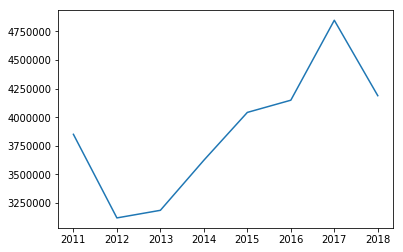

In [31]:
plt.plot(years,final_data.groupby('Year of Free Agency').mean()['Salary'])

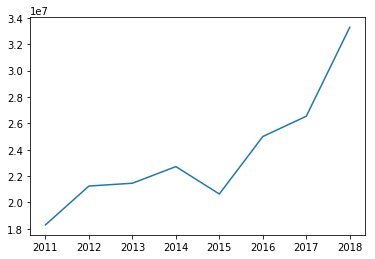

In [37]:
plt.plot(years,final_data.groupby('Year of Free Agency').max()['Salary'])

In [235]:
stats['LeBron James']['MP'].rolling(3,min_periods=1).mean()-stats['LeBron James']['MP']

TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [222]:
stats['Marc Gasol'][['MP','PTS']]

,MP,PTS
Player,,
Marc Gasol,31.9,11.7
Marc Gasol,36.5,14.6
Marc Gasol,35.0,14.1
Marc Gasol,33.4,14.6
Marc Gasol,33.2,17.4
Marc Gasol,34.4,16.6
Marc Gasol,34.2,19.5
Marc Gasol,33.0,17.2


In [236]:
stats['LeBron James']['MP']

Player
LeBron James    38.8
LeBron James    37.5
LeBron James    37.9
LeBron James    37.7
LeBron James    36.1
LeBron James    35.6
LeBron James    37.8
LeBron James    36.9
Name: MP, dtype: object